In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../../")
from classes.nn_classes import NNmodel
from classes.nn_classes import train_model as train_model_with_batch
from torch.utils.data import Dataset, DataLoader
from classes.atoms import Atom_Collection, Atom, Animator
from scipy.spatial.distance import cdist

In [3]:
class Atom_Plotter(Animator):
    def __init__(self, default_cols=("C0", "C1"), markersize=50, scale_with_mass=False, alpha=1) -> None:
        super().__init__(default_cols, markersize, scale_with_mass, alpha)
    
    def __call__(self, atom_col, ax=None, plot_cell=False):
        return super().__call__(atom_col, ax, plot_cell)

    def plot_atom_col(self, atom_col):
        ax = atom_col.plot_axes
        plot_elems = []
        if atom_col.plot_elems["atoms"] is None:
            for position, frozen, label in zip(atom_col.positions, atom_col.frozens, atom_col.label):
                if label == True:
                    self.alpha = 0.6
                else:
                    self.alpha = 1.0
                p = ax.plot(position[0], position[1], "o", c=self.default_cols[frozen.astype(int)], ms=self.markersize, alpha=self.alpha, markeredgecolor="k")[0]
                plot_elems.append(p)
        else:
            for position, plot_elem in zip(atom_col.positions, atom_col.plot_elems["atoms"]):
                plot_elem.set_data(position[0], position[1])
            plot_elems = atom_col.plot_elems["atoms"]
        return plot_elems

    def animate(self):
        return super().animate()

In [6]:
data = np.load('clusters_with_atomic_labels.npz')
for key in data:
    print(key, end='')
    if isinstance(data[key],np.ndarray):
        print(f", data['{key}'].shape =",data[key].shape, end='')
    print("")

positions, data['positions'].shape = (1000, 12, 2)
labels, data['labels'].shape = (1000, 12)


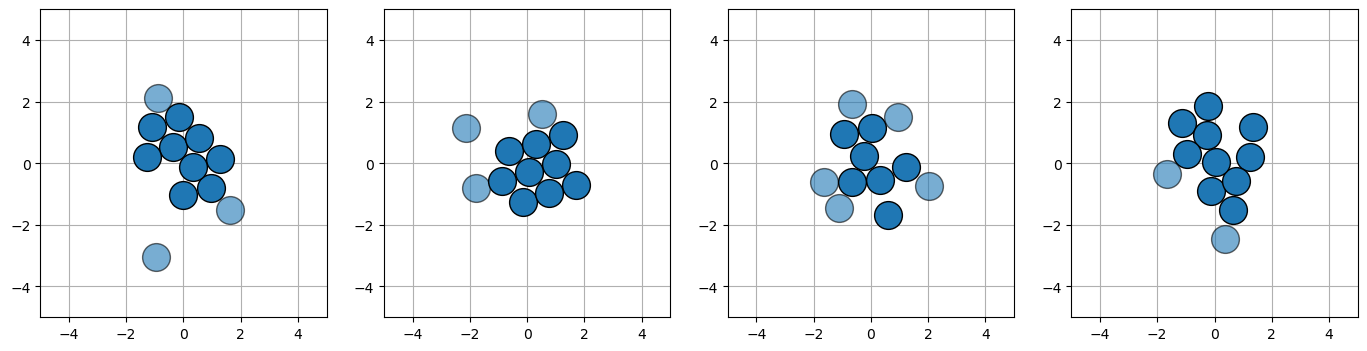

In [7]:
positions = np.array([position for position in data["positions"]])
labels = np.array([label for label in data["labels"]])
fig, axs = plt.subplots(1,4, figsize=(17,4))

atom_plotter = Atom_Plotter(markersize=20)

for pos_list, label_list, ax in zip(positions[0:4], labels[0:4], axs):
    ax.set_xlim([-5.0,5.0])
    ax.set_ylim([-5.0,5.0])
    atom_col = Atom_Collection(atomlist=[Atom(position=position) for position in pos_list])
    atom_col.label = label_list
    atom_plotter(atom_col=atom_col, ax=ax)
    ax.grid()

In [8]:
class GaussianRadial():
    def __init__(self, r_cut=7.0, sigma=0.3, desc_dim=32) -> None:
        self.r_cut = r_cut
        self.sigma = sigma
        self.desc_dim = desc_dim

    def calculate_f(self, r_ijs, r):
        if r < self.r_cut:
            r_evals = r_ijs - r
            t1 = np.exp(-(r_evals)**2/(2.0*self.sigma**2))
            t2 = np.cos(np.pi/2.0*r/self.r_cut)
            return np.sum(t1*t2, axis=1)
        else:
            return 0.0
    
    def calculate_features(self, atom_cluster_poses):
        rs = np.linspace(0.0, self.r_cut, self.desc_dim)
        try:
            M, N, D = atom_cluster_poses.shape
        except:
            raise Exception("The provided atom_cluster_poses does not match dimension of (#atom_clusters, #Positions, dim of positions)")
        
        features = np.zeros(shape=(M, N, self.desc_dim))
        for i, atom_poses in enumerate(atom_cluster_poses):
            diff = atom_poses[np.newaxis, :, :] - atom_poses[:, np.newaxis, :]
            r_mat = np.sqrt(np.sum(diff**2, axis=-1))
            #np.fill_diagonal(r_mat, np.inf) #Bjørk har ikke denne her, som så gør at han får i,i afstand med
            for j, r in enumerate(rs):
                features[i][:,j] = self.calculate_f(r_ijs=r_mat, r=r) 
        
        return features

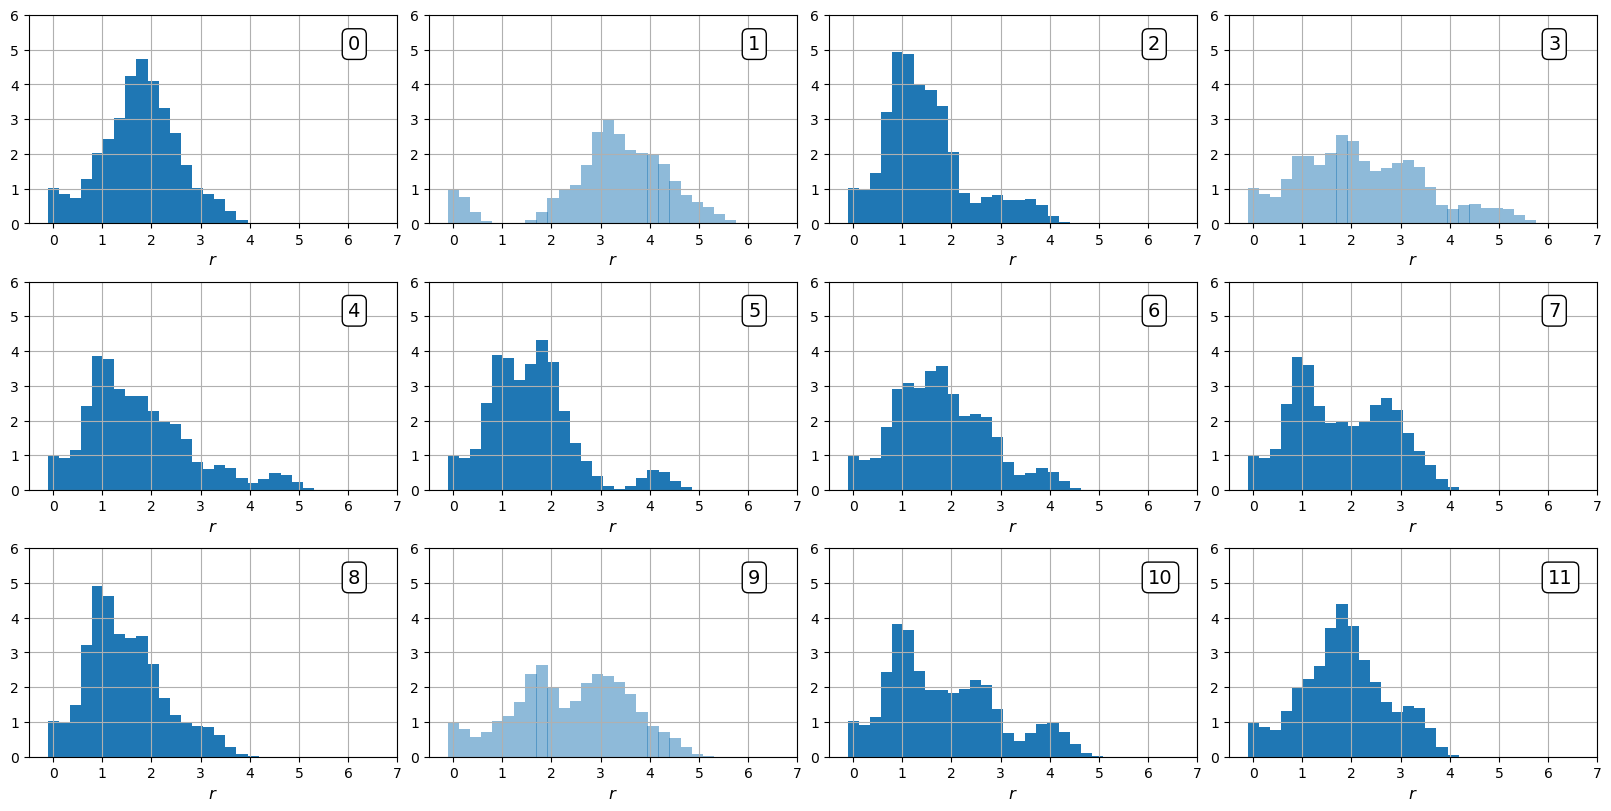

In [9]:
fig, axs = plt.subplots(3, 4, figsize=(16,8), layout="constrained")
feature_creator = GaussianRadial()
features = feature_creator.calculate_features(positions[0:1])
i = 0
for feature, label, ax in zip(features[0], labels[0], axs.flatten()):
    ax.set_xlabel(r"$r$", fontsize=12)
    ax.grid()
    ax.set_ylim([0,6.0])
    ax.set_xlim([-0.5,7.0])  
    ax.annotate(text=rf"{i}", xy=(6.0, 5.0), fontsize=14, bbox=dict(boxstyle="round", fc="w"))
    bin_centers = np.linspace(0.0, 7.0, 32)
    #ax.hist(feature)
    #ax.stairs(bin_centers, feature)
    ax.bar(bin_centers, feature, alpha=float(1.0-0.5*int(label)), width=0.23) #Muligvis fejl i bjørks kode, her tager han i,i afstanden med?
    i+=1


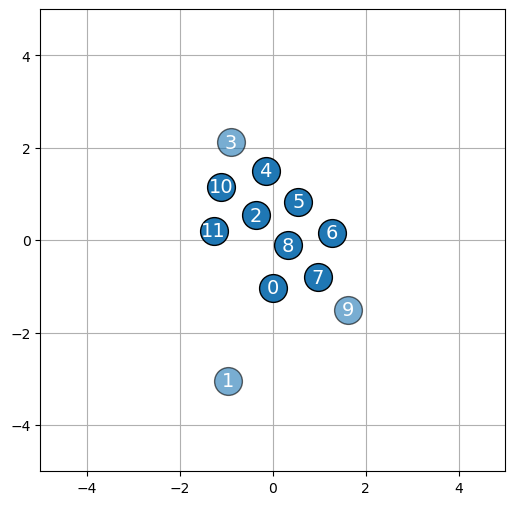

In [10]:
fig, ax = plt.subplots(figsize=(6,6))
ax.grid()
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
n = 0
atom_col = Atom_Collection(atomlist=[Atom(position=position) for position in positions[n]])
atom_col.label = labels[n]
atom_plotter = Atom_Plotter(markersize=20)
s = atom_plotter(atom_col=atom_col, ax=ax)
for i,pos in enumerate(positions[0]):
    ax.annotate(text=rf"{i}", xy=(pos[0], pos[1]), fontsize=14,va="center",ha="center", color="w")

In [8]:
class CustomDataset(Dataset):
    def __init__(self, features, labels) -> None:
        super().__init__()
        self.features = features
        self.labels = labels
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
    
    def __len__(self):
        return len(self.features)

In [9]:
positions = np.array([position for position in data["positions"]])
labels = np.array([label for label in data["labels"]])

feature_labels = torch.tensor([], dtype=torch.long)
features = torch.tensor([], dtype=torch.float)
feature_creator = GaussianRadial()
features_in_cluster = feature_creator.calculate_features(atom_cluster_poses=positions)
for cluster_features, label_list in zip(features_in_cluster, labels):
    features = torch.concat((features, torch.tensor(cluster_features, dtype=torch.float)))
    feature_labels = torch.concat((feature_labels, torch.tensor(label_list, dtype=torch.long)))

random_perm = torch.randperm(features.size()[0])
features = features[random_perm]
feature_labels = feature_labels[random_perm]

train_data_indices = torch.linspace(0, int(0.05*len(features))-1, int(0.05*len(features)), dtype=torch.int)
train_dataset = CustomDataset(features=features[train_data_indices], labels=feature_labels[train_data_indices])
val_data_indices = train_data_indices+train_data_indices[-1]
val_dataset = CustomDataset(features=features[val_data_indices], labels=feature_labels[val_data_indices])
test_dateset = CustomDataset(features=features[val_data_indices[-1]:], labels=feature_labels[val_data_indices[-1]:])

test_loader = DataLoader(test_dateset, batch_size=len(test_dateset), shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [10]:
class ClassModel(NNmodel):
    def __init__(self, input_dim, output_dim, num_hidden_layers, dim_hiddens, activation_func, bias=True) -> None:
        super().__init__(input_dim, output_dim, num_hidden_layers, dim_hiddens, activation_func, bias)
        self.softmax = torch.nn.Softmax(dim=1)

    def predict(self, x):
        return torch.argmax(self.softmax(self.forward(x)), dim=1)

In [84]:
models = {"shallow_model": ClassModel(input_dim=32, output_dim=2, num_hidden_layers=1, dim_hiddens=3, activation_func=torch.nn.SiLU(), bias=True),
          "deep_model":ClassModel(input_dim=32, output_dim=2, num_hidden_layers=6, dim_hiddens=42, activation_func=torch.nn.SiLU(), bias=True)
          }
model_losses = {"shallow_model":None,
                "deep_model":None,
                }
for model_name in models:
    model = models[model_name]
    optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-4)
    train_losses, val_losses, test_loss = train_model_with_batch(epochs=2000, model=model, 
                                                      train_loader=train_loader, 
                                                      val_loader=val_loader,
                                                      test_loader=test_loader,
                                                      optimizer=optimizer,
                                                      early_stopping=False,
                                                      loss_func=torch.nn.CrossEntropyLoss())
    model_losses[model_name] = (train_losses, val_losses, test_loss)

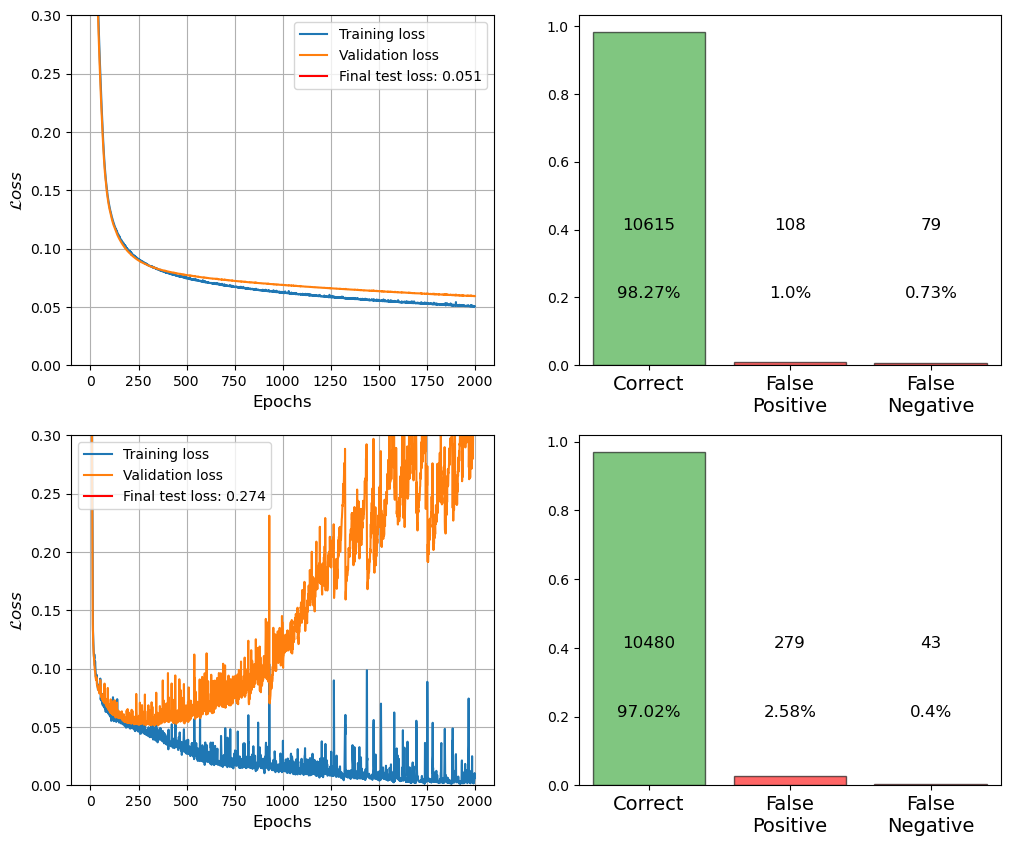

In [85]:
fig, axs = plt.subplots(2, 2, figsize=(12,10))

for model_name, ax_row in zip(models, axs):
    ax_row[1].set_xticks([0.0, 1.0, 2.0], labels=["Correct", "False\nPositive", "False\nNegative"], fontsize=14)
    ax_row[0].set_xlabel("Epochs", fontsize=12)
    ax_row[0].set_ylabel(r"$\mathcal{L}oss$", fontsize=12)
    ax_row[0].set_ylim([0.0, 0.3])
    correct_pred = 0
    true_false = 0
    false_true = 0
    ax_row[0].grid()
    with torch.no_grad():
        train_losses, val_losses, test_loss = model_losses[model_name]
        epochs = torch.linspace(0.0, len(train_losses), len(train_losses))
        ax_row[0].plot(epochs, train_losses, label="Training loss")
        ax_row[0].plot(epochs, val_losses, label="Validation loss")
        ax_row[0].plot([], [], c="r", label=f"Final test loss: {round(test_loss.item(),3)}")
        model = models[model_name]
        for features, labels in test_loader:
            labels_pred = model.predict(x=features)
            for label, label_pred in zip(labels, labels_pred):
                if label == label_pred:
                    correct_pred+=1
                else:
                    if label == 0 and label_pred == 1:
                        false_true+=1
                    if label == 1 and label_pred == 0:
                        true_false+=1
            #print(false_true)
            ax_row[1].set_xlim([-0.5,2.5])
            for i, pred, color in zip(range(0,3), [correct_pred, true_false, false_true], ["C2", "red", "red"]):
                ax_row[1].bar(i, pred/len(labels), color=color, alpha=0.6, edgecolor="k")
                ax_row[1].annotate(f"{round(pred/len(labels)*100, 2) }%", (i, 0.2), ha='center', fontsize=12)
                ax_row[1].annotate(f"{pred}", (i, 0.4), ha='center', fontsize=12)
    ax_row[0].legend()
plt.savefig("smalltrain-nostop.svg")


In [86]:
models = {"shallow_model": ClassModel(input_dim=32, output_dim=2, num_hidden_layers=1, dim_hiddens=3, activation_func=torch.nn.SiLU(), bias=True),
          "deep_model":ClassModel(input_dim=32, output_dim=2, num_hidden_layers=6, dim_hiddens=42, activation_func=torch.nn.SiLU(), bias=True)
          }
model_losses = {"shallow_model":None,
                "deep_model":None,
                }
for model_name in models:
    model = models[model_name]
    optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-4)
    train_losses, val_losses, test_loss = train_model_with_batch(epochs=6000, model=model, 
                                                      train_loader=train_loader, 
                                                      val_loader=val_loader,
                                                      test_loader=test_loader,
                                                      optimizer=optimizer,
                                                      early_stopping=True,
                                                      patience=20,
                                                      loss_func=torch.nn.CrossEntropyLoss())
    model_losses[model_name] = (train_losses, val_losses, test_loss)

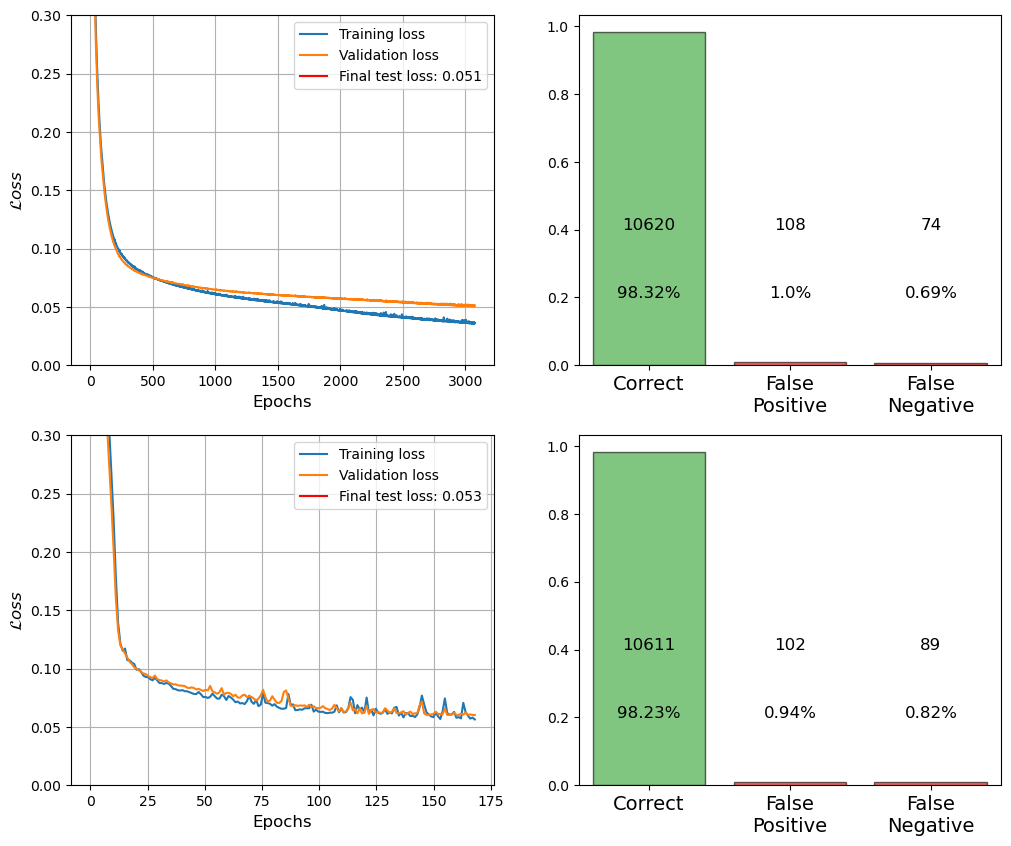

In [88]:
fig, axs = plt.subplots(2, 2, figsize=(12,10))

for model_name, ax_row in zip(models, axs):
    ax_row[1].set_xticks([0.0, 1.0, 2.0], labels=["Correct", "False\nPositive", "False\nNegative"], fontsize=14)
    ax_row[0].set_xlabel("Epochs", fontsize=12)
    ax_row[0].set_ylabel(r"$\mathcal{L}oss$", fontsize=12)
    ax_row[0].set_ylim([0.0, 0.3])
    correct_pred = 0
    true_false = 0
    false_true = 0
    ax_row[0].grid()
    with torch.no_grad():
        train_losses, val_losses, test_loss = model_losses[model_name]
        epochs = torch.linspace(0.0, len(train_losses), len(train_losses))
        ax_row[0].plot(epochs, train_losses, label="Training loss")
        ax_row[0].plot(epochs, val_losses, label="Validation loss")
        ax_row[0].plot([], [], c="r", label=f"Final test loss: {round(test_loss.item(),3)}")
        model = models[model_name]
        for features, labels in test_loader:
            labels_pred = model.predict(x=features)
            for label, label_pred in zip(labels, labels_pred):
                if label == label_pred:
                    correct_pred+=1
                else:
                    if label == 0 and label_pred == 1:
                        false_true+=1
                    if label == 1 and label_pred == 0:
                        true_false+=1
            #print(false_true)
            ax_row[1].set_xlim([-0.5,2.5])
            for i, pred, color in zip(range(0,3), [correct_pred, true_false, false_true], ["C2", "red", "red"]):
                ax_row[1].bar(i, pred/len(labels), color=color, alpha=0.6, edgecolor="k")
                ax_row[1].annotate(f"{round(pred/len(labels)*100, 2) }%", (i, 0.2), ha='center', fontsize=12)
                ax_row[1].annotate(f"{pred}", (i, 0.4), ha='center', fontsize=12)
    ax_row[0].legend()
plt.savefig("smalltrain-withstop.svg")

In [89]:
positions = np.array([position for position in data["positions"]])
labels = np.array([label for label in data["labels"]])

feature_labels = torch.tensor([], dtype=torch.long)
features = torch.tensor([], dtype=torch.float)
feature_creator = GaussianRadial()
features_in_cluster = feature_creator.calculate_features(atom_cluster_poses=positions)
for cluster_features, label_list in zip(features_in_cluster, labels):
    features = torch.concat((features, torch.tensor(cluster_features, dtype=torch.float)))
    feature_labels = torch.concat((feature_labels, torch.tensor(label_list, dtype=torch.long)))

random_perm = torch.randperm(features.size()[0])
features = features[random_perm]
feature_labels = feature_labels[random_perm]

train_data_indices = torch.linspace(0, int(0.8*len(features))-1, int(0.8*len(features)), dtype=torch.int)
train_dataset = CustomDataset(features=features[train_data_indices], labels=feature_labels[train_data_indices])
val_data_indices = torch.linspace(train_data_indices[-1], train_data_indices[-1]+int(0.1*len(features)), int(0.1*len(features)), dtype=int)
val_dataset = CustomDataset(features=features[val_data_indices], labels=feature_labels[val_data_indices])
test_dateset = CustomDataset(features=features[val_data_indices[-1]:], labels=feature_labels[val_data_indices[-1]:])

test_loader = DataLoader(test_dateset, batch_size=len(test_dateset), shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [90]:
models = {"shallow_model": ClassModel(input_dim=32, output_dim=2, num_hidden_layers=1, dim_hiddens=3, activation_func=torch.nn.SiLU(), bias=True),
          "deep_model":ClassModel(input_dim=32, output_dim=2, num_hidden_layers=6, dim_hiddens=42, activation_func=torch.nn.SiLU(), bias=True)
          }
model_losses = {"shallow_model":None,
                "deep_model":None,
                }
for model_name in models:
    model = models[model_name]
    optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-4)
    train_losses, val_losses, test_loss = train_model_with_batch(epochs=6000, model=model, 
                                                      train_loader=train_loader, 
                                                      val_loader=val_loader,
                                                      test_loader=test_loader,
                                                      optimizer=optimizer,
                                                      early_stopping=True,
                                                      patience=20,
                                                      loss_func=torch.nn.CrossEntropyLoss())
    model_losses[model_name] = (train_losses, val_losses, test_loss)

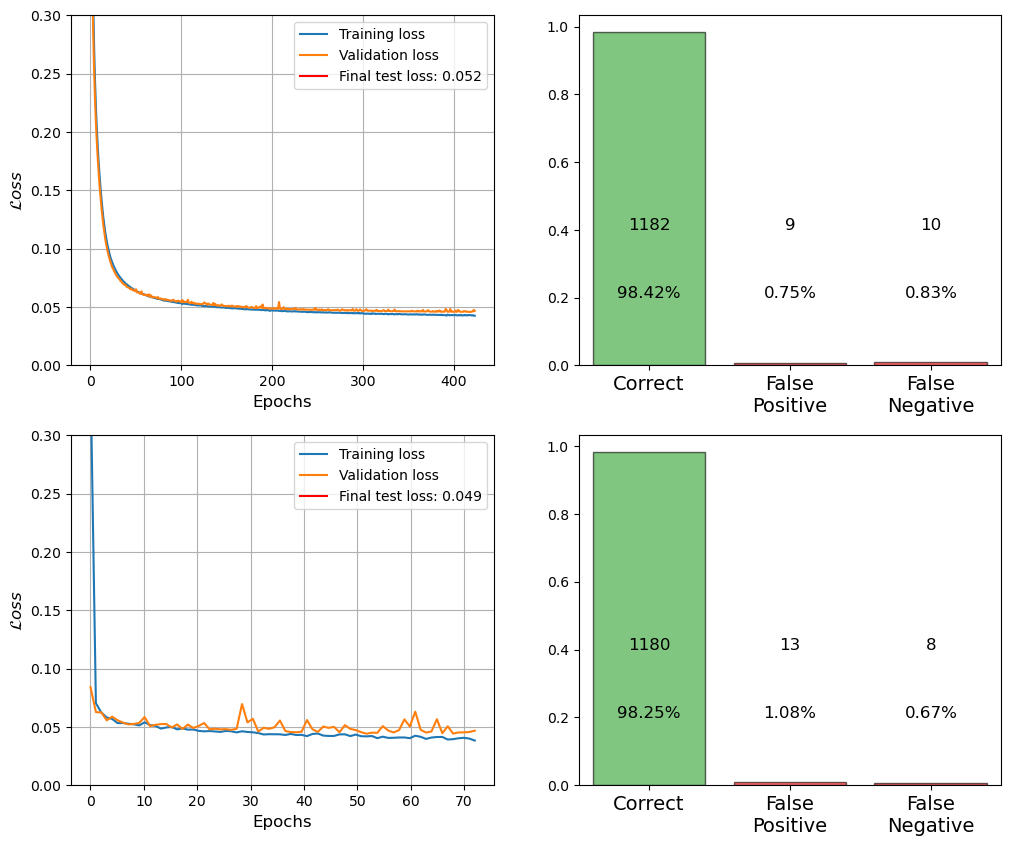

In [91]:
fig, axs = plt.subplots(2, 2, figsize=(12,10))

for model_name, ax_row in zip(models, axs):
    ax_row[1].set_xticks([0.0, 1.0, 2.0], labels=["Correct", "False\nPositive", "False\nNegative"], fontsize=14)
    ax_row[0].set_xlabel("Epochs", fontsize=12)
    ax_row[0].set_ylabel(r"$\mathcal{L}oss$", fontsize=12)
    ax_row[0].set_ylim([0.0, 0.3])
    correct_pred = 0
    true_false = 0
    false_true = 0
    ax_row[0].grid()
    with torch.no_grad():
        train_losses, val_losses, test_loss = model_losses[model_name]
        epochs = torch.linspace(0.0, len(train_losses), len(train_losses))
        ax_row[0].plot(epochs, train_losses, label="Training loss")
        ax_row[0].plot(epochs, val_losses, label="Validation loss")
        ax_row[0].plot([], [], c="r", label=f"Final test loss: {round(test_loss.item(),3)}")
        model = models[model_name]
        for features, labels in test_loader:
            labels_pred = model.predict(x=features)
            for label, label_pred in zip(labels, labels_pred):
                if label == label_pred:
                    correct_pred+=1
                else:
                    if label == 0 and label_pred == 1:
                        false_true+=1
                    if label == 1 and label_pred == 0:
                        true_false+=1
            #print(false_true)
            ax_row[1].set_xlim([-0.5,2.5])
            for i, pred, color in zip(range(0,3), [correct_pred, true_false, false_true], ["C2", "red", "red"]):
                ax_row[1].bar(i, pred/len(labels), color=color, alpha=0.6, edgecolor="k")
                ax_row[1].annotate(f"{round(pred/len(labels)*100, 2) }%", (i, 0.2), ha='center', fontsize=12)
                ax_row[1].annotate(f"{pred}", (i, 0.4), ha='center', fontsize=12)
    ax_row[0].legend()
plt.savefig("bigtrain-withstop.svg")

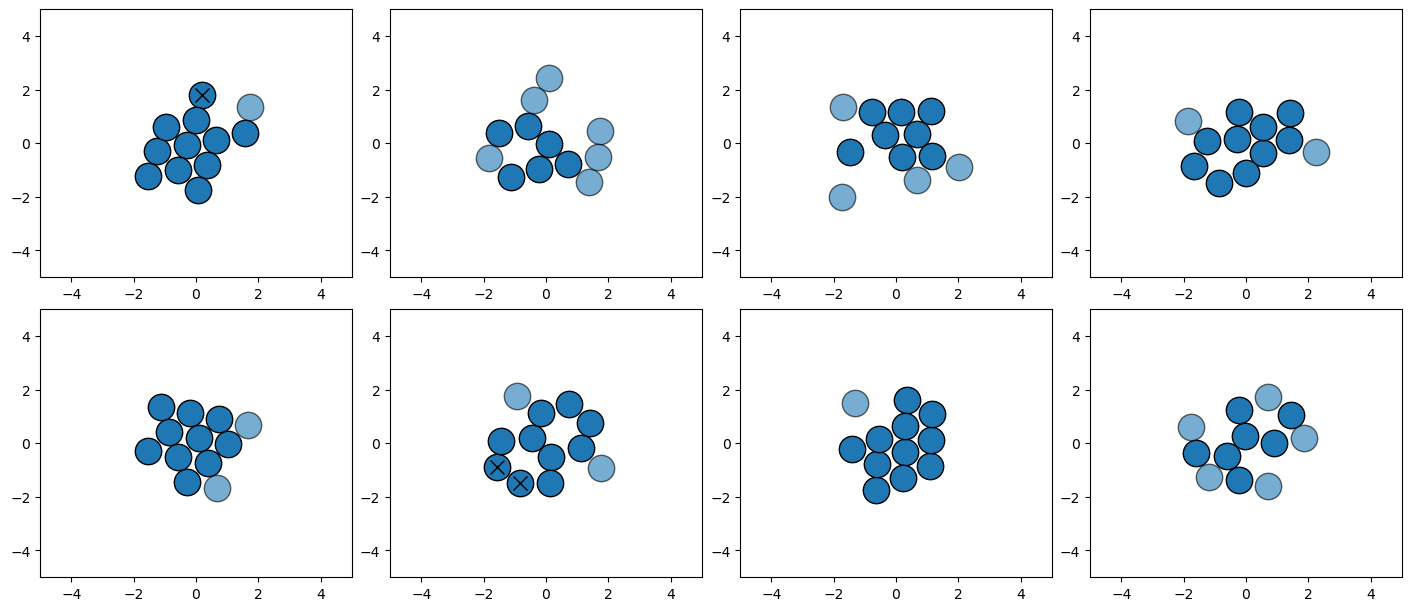

In [140]:
fig, axs = plt.subplots(2, 4, figsize=(14,6), layout="constrained")
indices = np.random.randint(0, 999, 8)
positions_for_pred = positions[indices]
labels_for_pred = labels[indices]
atom_plotter = Atom_Plotter(markersize=19)
feature_creator = GaussianRadial()
model = models["deep_model"]
for poses, labs, ax in zip(positions_for_pred,labels_for_pred,axs.flatten()):
    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])
    feature = feature_creator.calculate_features(np.array([poses]))[0]
    pred_labels = model.predict(torch.tensor(feature, dtype=torch.float))
    atom_col = Atom_Collection(atomlist=[Atom(position=pos) for pos in poses])
    atom_col.label=pred_labels.numpy().astype(bool)
    atom_plotter(atom_col=atom_col, ax=ax)
    for pos, lab, pred_lab in zip(poses, labs, pred_labels):
        if lab != pred_lab.numpy().astype(bool):
            ax.plot(pos[0], pos[1], "x", color="k", markersize=10)
plt.savefig("few_preds.svg")
            